# Diabetes risk prediction

Dataset: http://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.

### Importing necessary packages

In [75]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from statistics import mean
from scipy.stats import uniform

### Reading dataset

In [2]:
dataset = pd.read_csv('diabetes_data_upload.csv')
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [3]:
dataset.shape

(520, 17)

# Data processing

### Checking missing data

In [4]:
missing = dataset.isna()
missing.sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### Removing duplicates

In [5]:
dups = dataset.duplicated()
dropped = dataset.drop_duplicates()
dropped.shape

(251, 17)

### Changing from categorical to numerical values

In [6]:
dataset['Gender'] = [1 if g=='Male' else 0 for g in dataset.Gender]
dataset['class'] = [1 if c=='Positive' else 0 for c in dataset.get('class')]

cols_name = list(dataset)
cols_name = cols_name[2:16]

for col in cols_name:
    dataset[col] = [1 if b=='Yes' else 0 for b in dataset.get(col)]

dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


# Descriptive statistics

### Mean

In [7]:
dataset.mean()

Age                   48.028846
Gender                 0.630769
Polyuria               0.496154
Polydipsia             0.448077
sudden weight loss     0.417308
weakness               0.586538
Polyphagia             0.455769
Genital thrush         0.223077
visual blurring        0.448077
Itching                0.486538
Irritability           0.242308
delayed healing        0.459615
partial paresis        0.430769
muscle stiffness       0.375000
Alopecia               0.344231
Obesity                0.169231
class                  0.615385
dtype: float64

### Median

In [8]:
dataset.median()

Age                   47.5
Gender                 1.0
Polyuria               0.0
Polydipsia             0.0
sudden weight loss     0.0
weakness               1.0
Polyphagia             0.0
Genital thrush         0.0
visual blurring        0.0
Itching                0.0
Irritability           0.0
delayed healing        0.0
partial paresis        0.0
muscle stiffness       0.0
Alopecia               0.0
Obesity                0.0
class                  1.0
dtype: float64

### Standard deviation

In [9]:
dataset.std()

Age                   12.151466
Gender                 0.483061
Polyuria               0.500467
Polydipsia             0.497776
sudden weight loss     0.493589
weakness               0.492928
Polyphagia             0.498519
Genital thrush         0.416710
visual blurring        0.497776
Itching                0.500300
Irritability           0.428892
delayed healing        0.498846
partial paresis        0.495661
muscle stiffness       0.484589
Alopecia               0.475574
Obesity                0.375317
class                  0.486973
dtype: float64

### Preview

In [10]:
dataset.describe(include='all')

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,48.028846,0.630769,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231,0.615385
std,12.151466,0.483061,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317,0.486973
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.500000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Handling highly correlated features

[]


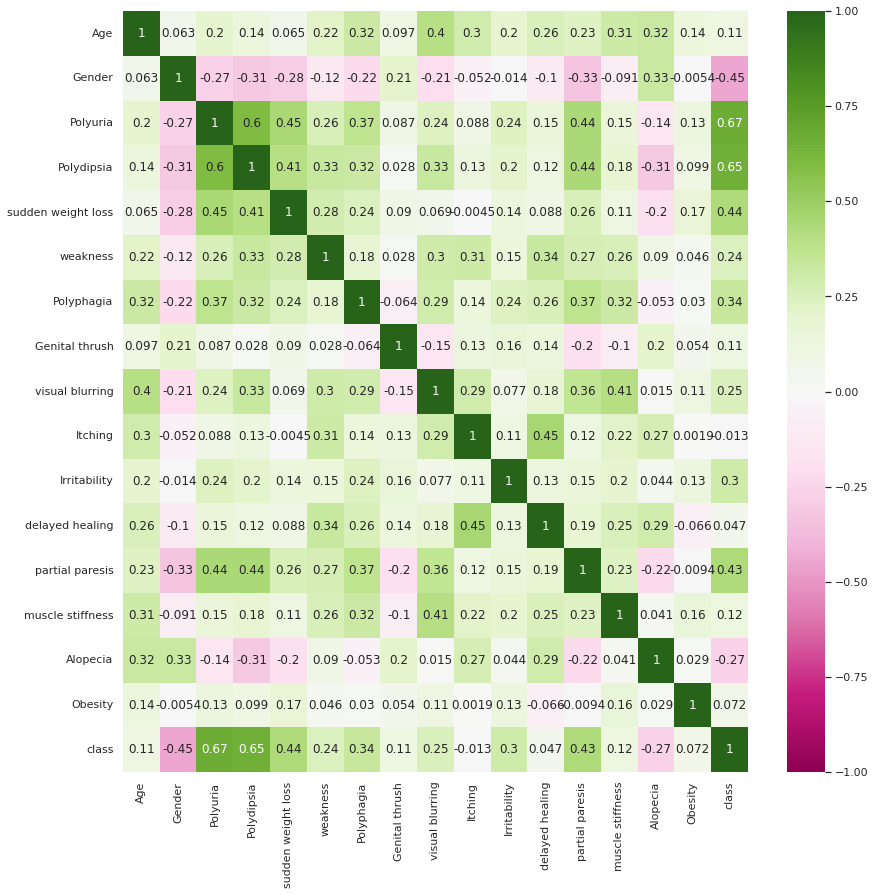

In [11]:
corr = dataset.corr()

sn.set(rc = {'figure.figsize':(14, 14)})
sn.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, cmap="PiYG")

upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

sn.reset_orig()

### Outliers detection

In [12]:
feature = dataset["Age"]

q1, q3 = np.percentile(feature, [25, 75])
iqr = q3 - q1
lower_bound = q1 - (iqr * 1.5)
upper_bound = q3 + (iqr * 1.5)
outliers = np.where((feature > upper_bound) | (feature < lower_bound))

dataset.iloc[outliers[0]]

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
101,85,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1
102,90,0,0,1,1,0,0,1,1,1,0,0,0,1,1,0,1
185,85,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1
186,90,0,0,1,1,0,0,1,1,1,0,0,0,1,1,0,1


### Positive/Negative

NEGATIVE:  200
POSITIVE:  320


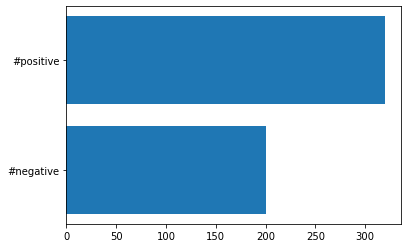

In [13]:
positive_count, negative_count = dataset['class'].value_counts()
plt.barh(["#negative","#positive"], [negative_count, positive_count])
print("NEGATIVE:  "+ str(negative_count))
print("POSITIVE:  "+ str(positive_count))

NEGATIVE:  78
POSITIVE:  173


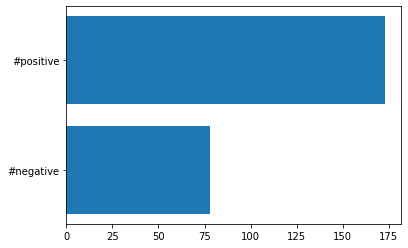

In [14]:
dropped_positive_count, dropped_negative_count = dropped['class'].value_counts()
plt.barh(["#negative","#positive"], [dropped_negative_count, dropped_positive_count])
print("NEGATIVE:  "+ str(dropped_negative_count))
print("POSITIVE:  "+ str(dropped_positive_count))

### Dataset balancing - UNDERSAMPLING
Ejecting random samples from a class with multiple instances

NEGATIVE:  200
POSITIVE:  200


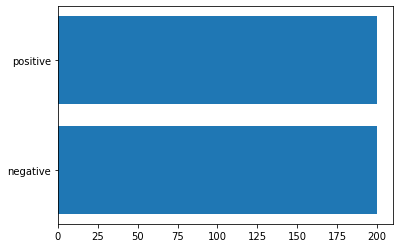

In [15]:
df_majority_US = dataset[dataset['class'] == 1]
df_minority_US = dataset[dataset['class'] == 0]

df_majority_undersampled = resample(df_majority_US, replace = False, n_samples = negative_count, random_state = 0)
df_undersampled = pd.concat([df_majority_undersampled, df_minority_US])
undersampled_positive_count, undersampled_negative_count = df_undersampled['class'].value_counts()

plt.barh(["negative","positive"], [undersampled_negative_count, undersampled_positive_count])
print("NEGATIVE:  "+ str(undersampled_negative_count))
print("POSITIVE:  "+ str(undersampled_positive_count))

### Dataset balancing - OVERSAMPLING
Adding duplicates from a class with fewer instances

NEGATIVE:  320
POSITIVE:  320


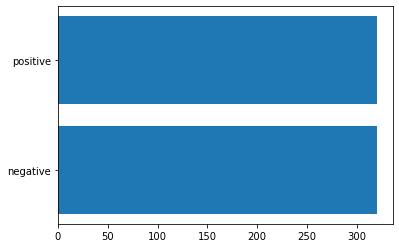

In [16]:
df_majority_OS = dataset[dataset['class'] == 1]
df_minority_OS = dataset[dataset['class'] == 0]

df_minority_upsampled = resample(df_minority_OS, replace=True, n_samples=positive_count, random_state=0)
df_upsampled = pd.concat([df_majority_OS, df_minority_upsampled])
oversampled_positive_count, oversampled_negative_count = df_upsampled['class'].value_counts()

plt.barh(["negative","positive"], [oversampled_negative_count, oversampled_positive_count])
print("NEGATIVE:  "+ str(oversampled_negative_count))
print("POSITIVE:  "+ str(oversampled_positive_count))

# Split dataseta to train and test

### imbalanced

In [17]:
X_imbalanced = dataset.drop("class", axis=1).values
y_imbalanced = dataset["class"].values

X_train_imbalanced ,X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(X_imbalanced,y_imbalanced,test_size = 0.2, random_state = 1)

### undersampling

In [18]:
X_undersampled = df_undersampled.drop("class",axis = 1).values
y_undersampled = df_undersampled["class"].values

X_train_undersampled,X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled,y_undersampled,test_size = 0.2, random_state = 1)

### upsampling

In [19]:
X_upsampled = df_upsampled.drop("class",axis = 1).values
y_upsampled = df_upsampled["class"].values

X_train_upsampled,X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled,y_upsampled,test_size = 0.2, random_state = 1)

# Additional functions

## Evaluate model

In [20]:
def eval_model(y_true_, y_pred_):
    accuracy = accuracy_score(y_true_, y_pred_)
    f1 = f1_score(y_true_, y_pred_)
    precision = precision_score(y_true_, y_pred_)
    recall = recall_score(y_true_, y_pred_)
    conf_matrix = confusion_matrix(y_true=y_true_, y_pred=y_pred_)
    TN, FP, FN, TP = conf_matrix.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print("Accuracy : ", accuracy)
    print("F1 Score: ", f1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Confuse matrix:")
    print(conf_matrix)
    print("True positive: ", TP)
    print("False positive: ", FP)
    print("True negative: ", TN)
    print("False negative: ", FN)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)

### Plot AUC-ROC curve

In [21]:
def auc_roc_plot(test, prediction):
    fpr, tpr, threshold = roc_curve(test, prediction)
    roc_auc = auc(fpr, tpr)

    plt.title('AUC-ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Plot confusion matrix

In [22]:
def plot_conf_matrix(matrix):
    class_names=['N','P']

    # Create pandas dataframe
    dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

    # Create heatmap
    sn.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

# Prediction algorithms with cross-validation

## LinearSVC

### imbalanced

In [23]:
scaler = StandardScaler()
svc_model = LinearSVC()

# create a pipeline that standardizes, that runs LinearSVC
pipeline = make_pipeline(scaler, svc_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
svc_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(svc_cv_results_imbalanced)
print("Mean: ", svc_cv_results_imbalanced.mean())

[0.86538462 0.92307692 0.90384615 0.86538462 0.96153846 0.88461538
 0.98076923 0.92307692 0.94230769 0.98076923]
Mean:  0.923076923076923


### undersampling

In [24]:
scaler = StandardScaler()
svc_model = LinearSVC()

# create a pipeline that standardizes, than runs LinearSVC
pipeline = make_pipeline(scaler, svc_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
svc_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(svc_cv_results_undersampled)
print("Mean: ", svc_cv_results_undersampled.mean())

[0.875 0.975 0.95  0.925 0.925 0.85  0.95  0.925 0.875 0.975]
Mean:  0.9225


### upsampling

In [25]:
scaler = StandardScaler()
svc_model = LinearSVC()

# create a pipeline that standardizes, than runs LinearSVC
pipeline = make_pipeline(scaler, svc_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
svc_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(svc_cv_results_upsampled)
print("Mean: ", svc_cv_results_upsampled.mean())

[0.890625 0.90625  0.953125 0.890625 0.953125 0.9375   0.9375   0.953125
 0.84375  0.953125]
Mean:  0.921875


### comparison imbalanced, undersampling, upsampling

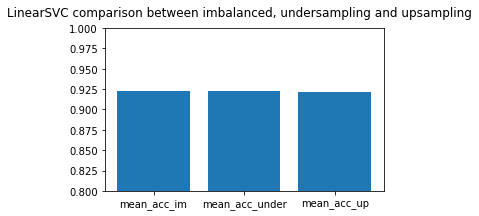

In [26]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [svc_cv_results_imbalanced.mean(), svc_cv_results_undersampled.mean(), svc_cv_results_upsampled.mean()])
plt.suptitle('LinearSVC comparison between imbalanced, undersampling and upsampling')
plt.show()

## Naive Bayes

### imbalanced

In [27]:
scaler = StandardScaler()
nb_model = GaussianNB()

# create a pipeline that standardizes, that runs Naive bayes
pipeline = make_pipeline(scaler, nb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
nb_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(nb_cv_results_imbalanced)
print("Mean: ", nb_cv_results_imbalanced.mean())

[0.84615385 0.90384615 0.86538462 0.86538462 0.88461538 0.90384615
 0.90384615 0.88461538 0.90384615 0.96153846]
Mean:  0.8923076923076924


### undersampling

In [28]:
scaler = StandardScaler()
nb_model = GaussianNB()

# create a pipeline that standardizes, that runs Naive bayes
pipeline = make_pipeline(scaler, nb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
nb_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(nb_cv_results_undersampled)
print("Mean: ", nb_cv_results_undersampled.mean())

[0.95  0.95  0.9   0.775 0.85  0.925 0.95  0.95  0.825 0.8  ]
Mean:  0.8875


### upsampling

In [29]:
scaler = StandardScaler()
nb_model = GaussianNB()

# create a pipeline that standardizes, that runs Naive bayes
pipeline = make_pipeline(scaler, nb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
nb_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(nb_cv_results_upsampled)
print("Mean: ", nb_cv_results_upsampled.mean())

[0.8125   0.875    0.9375   0.828125 0.875    0.859375 0.921875 0.921875
 0.875    0.90625 ]
Mean:  0.88125


### comparison imbalanced, undersampling, upsampling

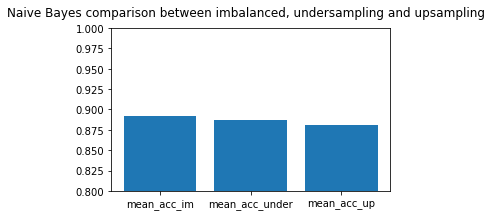

In [30]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [nb_cv_results_imbalanced.mean(), nb_cv_results_undersampled.mean(), nb_cv_results_upsampled.mean()])
plt.suptitle('Naive Bayes comparison between imbalanced, undersampling and upsampling')
plt.show()

## K-Nearest Neighbors

### imbalanced

In [31]:
scaler = StandardScaler()
knn_classifier = KNeighborsClassifier(n_neighbors=5)

pipeline = make_pipeline(scaler, knn_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
knn_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(knn_cv_results_imbalanced)
print("Mean: ", knn_cv_results_imbalanced.mean())

[0.84615385 0.98076923 0.94230769 0.90384615 0.94230769 0.92307692
 0.92307692 0.94230769 0.98076923 0.90384615]
Mean:  0.9288461538461539


### undersampling

In [32]:
scaler = StandardScaler()
knn_classifier = KNeighborsClassifier(n_neighbors=5)

pipeline = make_pipeline(scaler, knn_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
knn_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(knn_cv_results_undersampled)
print("Mean: ", knn_cv_results_undersampled.mean())

[0.95  0.95  0.95  0.85  0.975 0.875 0.925 0.95  0.875 0.975]
Mean:  0.9275


### upsampling

In [33]:
scaler = StandardScaler()
knn_classifier = KNeighborsClassifier(n_neighbors=5) # 3

pipeline = make_pipeline(scaler, knn_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
knn_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(knn_cv_results_upsampled)
print("Mean: ", knn_cv_results_upsampled.mean())

[0.90625  0.984375 0.953125 0.96875  0.96875  0.953125 0.9375   0.96875
 0.90625  0.921875]
Mean:  0.946875


### comparison imbalanced, undersampling, upsampling

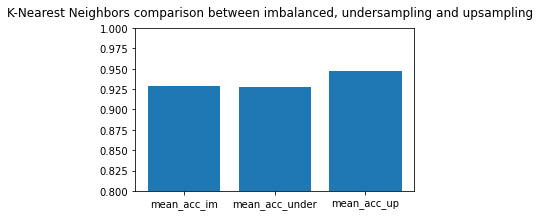

In [34]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [knn_cv_results_imbalanced.mean(), knn_cv_results_undersampled.mean(), knn_cv_results_upsampled.mean()])
plt.suptitle('K-Nearest Neighbors comparison between imbalanced, undersampling and upsampling')
plt.show()

## Logistic Regression

### imbalanced 

In [35]:
scaler = StandardScaler()
lr_classifier = LogisticRegression()

pipeline = make_pipeline(scaler, lr_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lr_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(lr_cv_results_imbalanced)
print("Mean: ", lr_cv_results_imbalanced.mean())

[0.86538462 0.92307692 0.90384615 0.84615385 0.96153846 0.88461538
 0.98076923 0.92307692 0.96153846 0.98076923]
Mean:  0.923076923076923


### undersampling

In [36]:
scaler = StandardScaler()
lr_classifier = LogisticRegression()

pipeline = make_pipeline(scaler, lr_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lr_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(lr_cv_results_undersampled)
print("Mean: ", lr_cv_results_undersampled.mean())

[0.925 0.975 0.95  0.925 0.925 0.85  0.975 0.925 0.875 0.975]
Mean:  0.9299999999999999


### upsampling

In [37]:
scaler = StandardScaler()
lr_classifier = LogisticRegression()

pipeline = make_pipeline(scaler, lr_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lr_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(lr_cv_results_upsampled)
print("Mean: ", lr_cv_results_upsampled.mean())

[0.890625 0.921875 0.953125 0.890625 0.9375   0.953125 0.9375   0.96875
 0.84375  0.953125]
Mean:  0.925


### comparison imbalanced, undersampling, upsampling

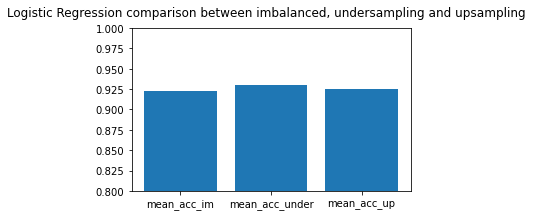

In [38]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [lr_cv_results_imbalanced.mean(), lr_cv_results_undersampled.mean(), lr_cv_results_upsampled.mean()])
plt.suptitle('Logistic Regression comparison between imbalanced, undersampling and upsampling')
plt.show()

## Decision tree

### imbalanced

In [39]:
scaler = StandardScaler()
dt_classifier = DecisionTreeClassifier(random_state=0)

pipeline = make_pipeline(scaler, dt_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dt_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(dt_cv_results_imbalanced)
print("Mean: ", dt_cv_results_imbalanced.mean())

[0.92307692 0.98076923 0.98076923 0.94230769 0.94230769 0.90384615
 1.         0.98076923 0.88461538 0.98076923]
Mean:  0.9519230769230769


### undersampling

In [40]:
scaler = StandardScaler()
dt_classifier = DecisionTreeClassifier(random_state=0)

pipeline = make_pipeline(scaler, dt_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dt_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(dt_cv_results_undersampled)
print("Mean: ", dt_cv_results_undersampled.mean())

[0.975 0.975 0.95  0.925 0.925 0.9   0.95  0.975 0.975 0.975]
Mean:  0.9525


### upsampling

In [41]:
scaler = StandardScaler()
dt_classifier = DecisionTreeClassifier(random_state=0)

pipeline = make_pipeline(scaler, dt_classifier)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dt_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(dt_cv_results_upsampled)
print("Mean: ", dt_cv_results_upsampled.mean())

[0.953125 1.       1.       0.953125 0.984375 0.96875  0.984375 0.984375
 0.953125 1.      ]
Mean:  0.978125


### comparison imbalanced, undersampling, upsampling

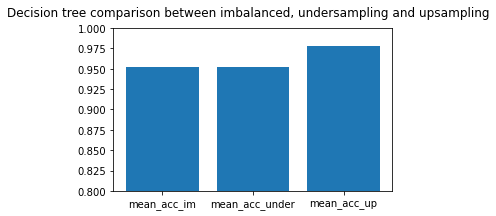

In [42]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [dt_cv_results_imbalanced.mean(), dt_cv_results_undersampled.mean(), dt_cv_results_upsampled.mean()])
plt.suptitle('Decision tree comparison between imbalanced, undersampling and upsampling')
plt.show()

## Gradient Boost

### imbalanced

In [43]:
scaler = StandardScaler()
gb_model = GradientBoostingClassifier(learning_rate=0.1)

pipeline = make_pipeline(scaler, gb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
gb_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(gb_cv_results_imbalanced)
print("Mean: ", gb_cv_results_imbalanced.mean())

[0.96153846 0.98076923 0.98076923 0.92307692 0.94230769 0.96153846
 0.98076923 1.         0.96153846 0.98076923]
Mean:  0.9673076923076922


### undersampling

In [44]:
scaler = StandardScaler()
gb_model = GradientBoostingClassifier(learning_rate=0.1)

pipeline = make_pipeline(scaler, gb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
gb_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(gb_cv_results_undersampled)
print("Mean: ", gb_cv_results_undersampled.mean())

[0.95  0.975 0.95  0.95  0.975 0.95  0.95  0.975 0.925 1.   ]
Mean:  0.96


### upsampling

In [45]:
scaler = StandardScaler()
gb_model = GradientBoostingClassifier(learning_rate=0.1)

pipeline = make_pipeline(scaler, gb_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
gb_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(gb_cv_results_upsampled)
print("Mean: ", gb_cv_results_upsampled.mean())

[0.96875  1.       0.984375 0.953125 0.984375 0.96875  0.984375 1.
 0.9375   1.      ]
Mean:  0.978125


### comparison imbalanced, undersampling, upsampling

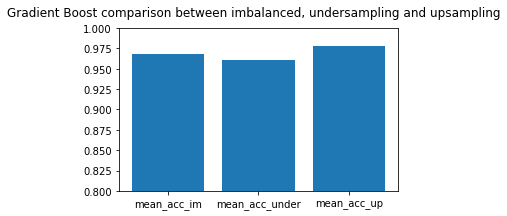

In [46]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [gb_cv_results_imbalanced.mean(), gb_cv_results_undersampled.mean(), gb_cv_results_upsampled.mean()])
plt.suptitle('Gradient Boost comparison between imbalanced, undersampling and upsampling')
plt.show()

## Random forest

### imbalanced

In [47]:
scaler = StandardScaler()
rf_model = RandomForestClassifier()

pipeline = make_pipeline(scaler, rf_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(rf_cv_results_imbalanced)
print("Mean: ", rf_cv_results_imbalanced.mean())

[0.96153846 0.98076923 0.98076923 0.96153846 0.96153846 0.96153846
 0.98076923 1.         0.98076923 1.        ]
Mean:  0.9769230769230768


### undersampling

In [48]:
scaler = StandardScaler()
rf_model = RandomForestClassifier()

pipeline = make_pipeline(scaler, rf_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(rf_cv_results_undersampled)
print("Mean: ", rf_cv_results_undersampled.mean())

[0.975 0.975 0.95  0.95  0.975 0.925 1.    0.975 0.95  1.   ]
Mean:  0.9674999999999999


### upsampling

In [49]:
scaler = StandardScaler()
rf_model = RandomForestClassifier()

pipeline = make_pipeline(scaler, rf_model)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(rf_cv_results_upsampled)
print("Mean: ", rf_cv_results_upsampled.mean())

[0.96875  1.       1.       0.96875  0.984375 1.       0.984375 1.
 0.96875  1.      ]
Mean:  0.9875


### comparison imbalanced, undersampling, upsampling

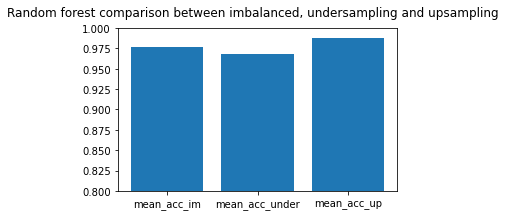

In [50]:
plt.figure(figsize=(5, 3))
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [rf_cv_results_imbalanced.mean(), rf_cv_results_undersampled.mean(), rf_cv_results_upsampled.mean()])
plt.suptitle('Random forest comparison between imbalanced, undersampling and upsampling')
plt.show()

## Baseline classifier - DummyClassifier

### imbalanced

In [51]:
scaler = StandardScaler()
dummy = DummyClassifier(strategy='stratified', random_state=1)

pipeline = make_pipeline(scaler, dummy)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dummy_cv_results_imbalanced = cross_val_score(pipeline, X_imbalanced, y_imbalanced, cv=kf, scoring="accuracy", n_jobs=-1)

print(dummy_cv_results_imbalanced)
print("Mean: ", dummy_cv_results_imbalanced.mean())

[0.57692308 0.57692308 0.57692308 0.65384615 0.5        0.53846154
 0.5        0.53846154 0.65384615 0.57692308]
Mean:  0.5692307692307692


### undersampling

In [52]:
scaler = StandardScaler()
dummy = DummyClassifier(strategy='stratified', random_state=1)

pipeline = make_pipeline(scaler, dummy)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dummy_cv_results_undersampled = cross_val_score(pipeline, X_undersampled, y_undersampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(dummy_cv_results_undersampled)
print("Mean: ", dummy_cv_results_undersampled.mean())

[0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65]
Mean:  0.6500000000000001


### upsampling

In [53]:
scaler = StandardScaler()
dummy = DummyClassifier(strategy='stratified', random_state=1)

pipeline = make_pipeline(scaler, dummy)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
dummy_cv_results_upsampled = cross_val_score(pipeline, X_upsampled, y_upsampled, cv=kf, scoring="accuracy", n_jobs=-1)

print(dummy_cv_results_upsampled)
print("Mean: ", dummy_cv_results_upsampled.mean())

[0.546875 0.546875 0.546875 0.546875 0.546875 0.546875 0.546875 0.546875
 0.546875 0.546875]
Mean:  0.546875


# Comparison between different algorithms

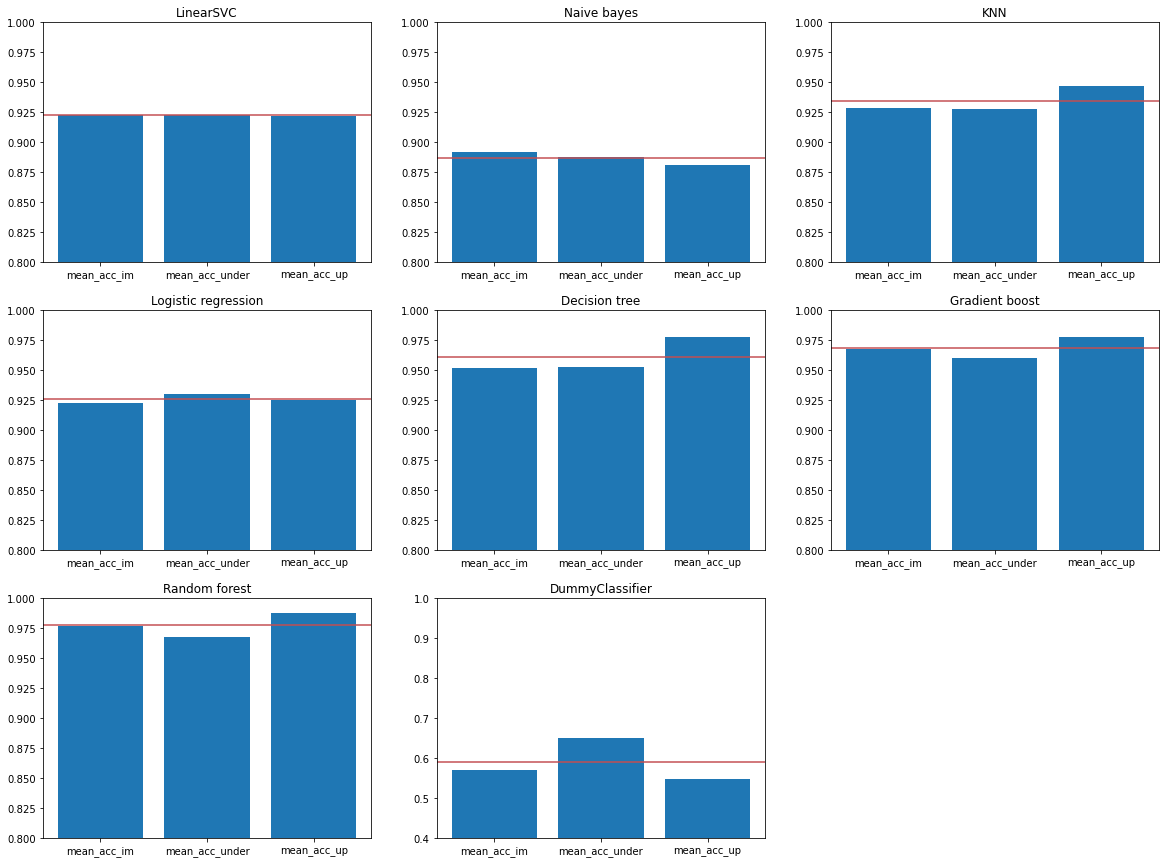

In [54]:
plt.figure(figsize=(20, 15))
plt.subplot(331)
plt.gca().set_title('LinearSVC')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [svc_cv_results_imbalanced.mean(), svc_cv_results_undersampled.mean(), svc_cv_results_upsampled.mean()])
plt.axhline(y = mean([svc_cv_results_imbalanced.mean(), svc_cv_results_undersampled.mean(), svc_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')
plt.subplot(332)
plt.gca().set_title('Naive bayes')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [nb_cv_results_imbalanced.mean(), nb_cv_results_undersampled.mean(), nb_cv_results_upsampled.mean()])
plt.axhline(y = mean([nb_cv_results_imbalanced.mean(), nb_cv_results_undersampled.mean(), nb_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')
plt.subplot(333)
plt.gca().set_title('KNN')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [knn_cv_results_imbalanced.mean(), knn_cv_results_undersampled.mean(), knn_cv_results_upsampled.mean()])
plt.axhline(y = mean([knn_cv_results_imbalanced.mean(), knn_cv_results_undersampled.mean(), knn_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')

plt.subplot(334)
plt.gca().set_title('Logistic regression')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [lr_cv_results_imbalanced.mean(), lr_cv_results_undersampled.mean(), lr_cv_results_upsampled.mean()])
plt.axhline(y = mean([lr_cv_results_imbalanced.mean(), lr_cv_results_undersampled.mean(), lr_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')
plt.subplot(335)
plt.gca().set_title('Decision tree')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [dt_cv_results_imbalanced.mean(), dt_cv_results_undersampled.mean(), dt_cv_results_upsampled.mean()])
plt.axhline(y = mean([dt_cv_results_imbalanced.mean(), dt_cv_results_undersampled.mean(), dt_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')
plt.subplot(336)
plt.gca().set_title('Gradient boost')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [gb_cv_results_imbalanced.mean(), gb_cv_results_undersampled.mean(), gb_cv_results_upsampled.mean()])
plt.axhline(y = mean([gb_cv_results_imbalanced.mean(), gb_cv_results_undersampled.mean(), gb_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')

plt.subplot(337)
plt.gca().set_title('Random forest')
plt.ylim(0.8, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [rf_cv_results_imbalanced.mean(), rf_cv_results_undersampled.mean(), rf_cv_results_upsampled.mean()])
plt.axhline(y = mean([rf_cv_results_imbalanced.mean(), rf_cv_results_undersampled.mean(), rf_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')
plt.subplot(338)
plt.gca().set_title('DummyClassifier')
plt.ylim(0.4, 1.00)
plt.bar(['mean_acc_im', 'mean_acc_under', 'mean_acc_up'], [dummy_cv_results_imbalanced.mean(), dummy_cv_results_undersampled.mean(), dummy_cv_results_upsampled.mean()])
plt.axhline(y = mean([dummy_cv_results_imbalanced.mean(), dummy_cv_results_undersampled.mean(), dummy_cv_results_upsampled.mean()]), color = 'r', linestyle = '-')

plt.show()

### Selected algorithms: Gradient boost and Logistic regression

# Gradient boost

## Hyperparameters - definition

### Tree-Specific parameters: (These affect each individual tree in the model)
#### min_samples_split
Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.

#### min_samples_leaf
Defines the minimum samples (or observations) required in a terminal node or leaf.
Used to control over-fitting similar to min_samples_split.
Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.

#### min_weight_fraction_leaf
Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.
Only one of #2 and #3 should be defined.

#### max_depth
The maximum depth of a tree.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.

#### max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.

#### max_features
The number of features to consider while searching for a best split. These will be randomly selected.
As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
Higher values can lead to over-fitting but depends on case to case.

### Boosting parameters: (These affect the boosting operation in the model)
#### learning_rate:  (default = 0.1)
This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
Lower values would require higher number of trees to model all the relations and will be computationally expensive.

#### n_estimators:
The number of sequential trees to be modeled (step 2)
Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.

#### subsample
The fraction of observations to be selected for each tree. Selection is done by random sampling.
Values slightly less than 1 make the model robust by reducing the variance.
Typical values ~0.8 generally work fine but can be fine-tuned further.

### Miscellaneous Parameters: (Other parameters for overall functioning)
#### loss
It refers to the loss function to be minimized in each split.
It can have various values for classification and regression case. Generally the default values work fine. Other values should be chosen only if you understand their impact on the model.

#### init
This affects initialization of the output.
This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.

#### random_state
The random number seed so that same random numbers are generated every time.
This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.

#### verbose
The type of output to be printed when the model fits. The different values can be:
0: no output generated (default)
1: output generated for trees in certain intervals
>1: output generated for all trees

#### warm_start
This parameter has an interesting application and can help a lot if used judicially.
Using this, we can fit additional trees on previous fits of a model. It can save a lot of time and you should explore this option for advanced applications

#### presort 
 Select whether to presort data for faster splits.
It makes the selection automatically by default but it can be changed if needed.

## Baseline Gradient boost

Accuracy :  0.984375
F1 Score:  0.9821428571428571
Precision:  0.9821428571428571
Recall:  0.9821428571428571
Confuse matrix:
[[71  1]
 [ 1 55]]
True positive:  55
False positive:  1
True negative:  71
False negative:  1
Sensitivity:  0.9821428571428571
Specificity:  0.9861111111111112

All Gradient Boost params:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


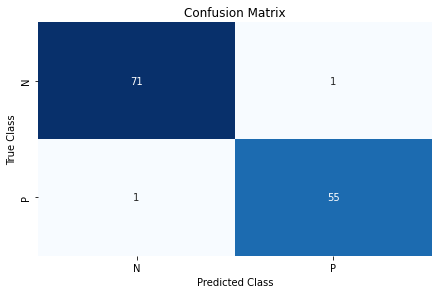

In [55]:
gb_model = GradientBoostingClassifier()

params = gb_model.get_params()

gb_model.fit(X_train_upsampled, y_train_upsampled)
gb_prediction_upsampled = gb_model.predict(X_test_upsampled)

# model evaluation
eval_model(y_test_upsampled, gb_prediction_upsampled)

print()
print("All Gradient Boost params:")
print(params)

# Create confusion matrix
matrix = confusion_matrix(y_test_upsampled, gb_prediction_upsampled)

plot_conf_matrix(matrix)

## Hyperparameters tuning using randomized search

Best params:  {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 33, 'min_samples_leaf': 5, 'max_features': 5, 'max_depth': 13, 'learning_rate': 0.15}
Best score:  0.9746620978488483

Accuracy :  1.0
F1 Score:  1.0
Precision:  1.0
Recall:  1.0
Confuse matrix:
[[72  0]
 [ 0 56]]
True positive:  56
False positive:  0
True negative:  72
False negative:  0
Sensitivity:  1.0
Specificity:  1.0


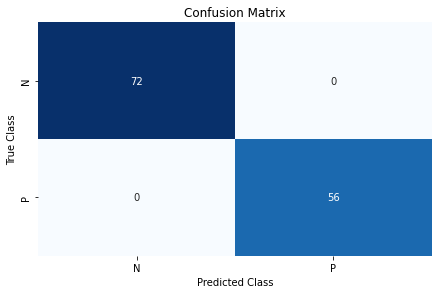

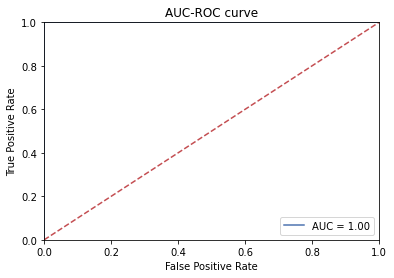

In [56]:
# Create Gradient Boosting
gb_classifier = GradientBoostingClassifier()

# Create hyperparameters values
learning_rate = [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
n_estimators = [3, 7, 15, 20, 30, 50]
subsample = [0.5, 0.75, 0.8, 0.95, 1.0]

max_depth = uniform(loc=5, scale=20).rvs(10).astype(int)
min_samples_split = uniform(loc=2, scale=60).rvs(15).astype(int)
min_samples_leaf = [1, 3, 5, 7, 9]
max_features = [3, 4, 5, 6, 7, 12]

# Create hyperparameter options
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators,
                       subsample=subsample, max_depth=max_depth, min_samples_split=min_samples_split,
                      min_samples_leaf=min_samples_leaf, max_features=max_features)

# Create randomized search
randomizedsearch = RandomizedSearchCV(gb_classifier, hyperparameters, random_state=1, 
                                      n_iter=100, cv=5, verbose=0, n_jobs=-1)

# Fit randomized search
best_model = randomizedsearch.fit(X_train_upsampled, y_train_upsampled)
 
print("Best params: ", randomizedsearch.best_params_)
print("Best score: ", randomizedsearch.best_score_)
print()

rs_prediction_upsampled = best_model.predict(X_test_upsampled)

# model evaluation
eval_model(y_test_upsampled, rs_prediction_upsampled)

# Create confusion matrix
matrix = confusion_matrix(y_test_upsampled, rs_prediction_upsampled)

plot_conf_matrix(matrix)

auc_roc_plot(y_test_upsampled, rs_prediction_upsampled)

### Efect of training set size

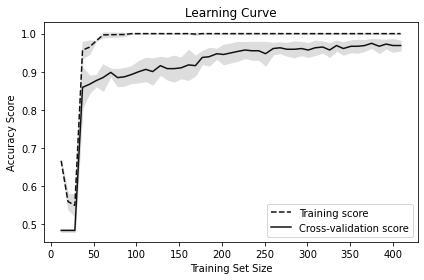

In [74]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.set_params(**best_model.best_estimator_.get_params())

train_sizes, train_scores, test_scores = learning_curve(gb_classifier, X_train_upsampled, y_train_upsampled, cv=5,
    scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Effect of hyperparameter values

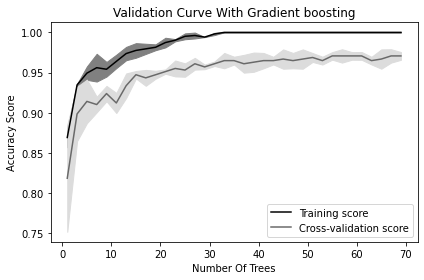

In [58]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.set_params(**best_model.best_estimator_.get_params())

# Create range of values for parameter n_estimators
param_range = np.arange(1, 70, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
 # Classifier
 gb_classifier,
 # Feature matrix
 X_train_upsampled,
 # Target vector
 y_train_upsampled,
 # Hyperparameter to examine
 param_name="n_estimators",
 # Range of hyperparameter's values
 param_range=param_range,
 # Number of folds
 cv=3,
 # Performance metric
 scoring="accuracy",
 # Use all computer cores
 n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Gradient boosting")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()

### Feature importances

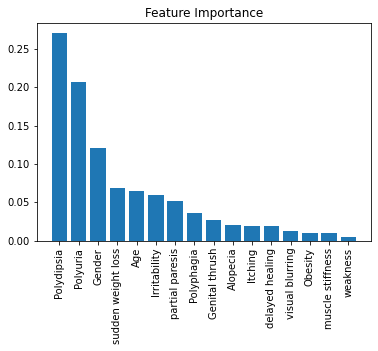

In [59]:
# Calculate feature importances
importances = best_model.best_estimator_.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [dataset.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train_upsampled.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train_upsampled.shape[1]), names, rotation=90)

# Show plot
plt.show()

### Recursive feature elimination - RFE (Dimensionality reduction)

In [60]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.set_params(**best_model.best_estimator_.get_params()) 

rfe_model = RFE(gb_classifier, n_features_to_select = 5)

rfe_prediction = rfe_model.fit(X_train_upsampled, y_train_upsampled)
feature_list = rfe_prediction.get_support(indices=True)
key_columns = []
for feature in feature_list:
    print(df_upsampled.columns[feature])
    key_columns.append(df_upsampled.columns[feature])
key_columns.append("class")

Age
Gender
Polyuria
Polydipsia
Irritability


In [61]:
columns_to_remove = []
df_rfe = df_upsampled.copy(deep=True)
for column in df_rfe.columns:
    if column not in key_columns:
        columns_to_remove.append(column)
        
rfe_removed = df_rfe.drop(columns_to_remove, axis=1)
rfe_removed.head()

,Age,Gender,Polyuria,Polydipsia,Irritability,class
0,40,1,0,1,0,1
1,58,1,0,0,0,1
2,41,1,1,0,0,1
3,45,1,0,0,0,1
4,60,1,1,1,1,1


Accuracy :  0.96875
F1 Score:  0.9636363636363636
Precision:  0.9814814814814815
Recall:  0.9464285714285714
Confuse matrix:
[[71  1]
 [ 3 53]]
True positive:  53
False positive:  1
True negative:  71
False negative:  3
Sensitivity:  0.9464285714285714
Specificity:  0.9861111111111112


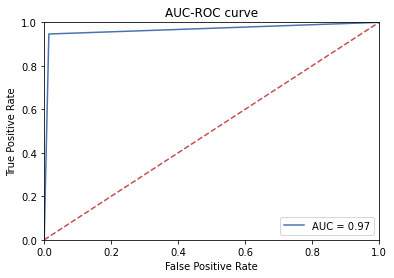

In [62]:
X = rfe_removed.drop("class", axis = 1).values
y = rfe_removed["class"].values
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X, y, test_size = 0.2, random_state = 1)

rfe_best_model = GradientBoostingClassifier()
rfe_best_model.set_params(**best_model.best_estimator_.get_params())
rfe_best_model.fit(X_train_rfe, y_train_rfe)
rfe_prediction = rfe_best_model.predict(X_test_rfe)

eval_model(y_test_upsampled, rfe_prediction)

auc_roc_plot(y_test_upsampled, rfe_prediction)

### Principal component analysis - PCA (Dimensionality reduction)

Accuracy :  0.9609375
F1 Score:  0.9557522123893805
Precision:  0.9473684210526315
Recall:  0.9642857142857143
Confuse matrix:
[[69  3]
 [ 2 54]]
True positive:  54
False positive:  3
True negative:  69
False negative:  2
Sensitivity:  0.9642857142857143
Specificity:  0.9583333333333334


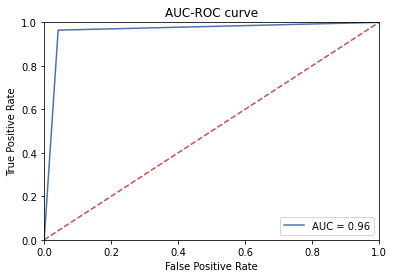

In [63]:
pca = PCA(n_components = 6)
X_train_upsampled_pca = pca.fit_transform(X_train_upsampled)
X_test_upsampled_pca = pca.transform(X_test_upsampled)

gb_classifier = GradientBoostingClassifier()
gb_classifier.set_params(**best_model.best_estimator_.get_params()) 

gb_classifier.fit(X_train_upsampled_pca, y_train_upsampled)
pca_prediction = gb_classifier.predict(X_test_upsampled_pca)

eval_model(y_test_upsampled, pca_prediction)

auc_roc_plot(y_test_upsampled, pca_prediction)

# Logistic regression

## Hyperparameters

#### Solver - {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
    Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the 
    following aspects:
        - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
        - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
        - ‘liblinear’ is limited to one-versus-rest schemes.
#### C
    Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify 
    stronger regularization.
#### Penalty - {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}
    'none': no penalty is added;
    'l2': add a L2 penalty term and it is the default choice;
    'l1': add a L1 penalty term;
    'elasticnet': both L1 and L2 penalty terms are added  

## Baseline Logistic regression

Accuracy :  0.9230769230769231
F1 Score:  0.9393939393939394
Precision:  0.9393939393939394
Recall:  0.9393939393939394
Confuse matrix:
[[34  4]
 [ 4 62]]
True positive:  62
False positive:  4
True negative:  34
False negative:  4
Sensitivity:  0.9393939393939394
Specificity:  0.8947368421052632


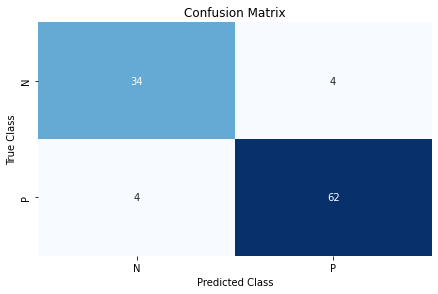

In [64]:
scaler = StandardScaler()
lg_classifier = LogisticRegression()

X_train_imbalanced_transformed = scaler.fit_transform(X_train_imbalanced)
X_test_imbalanced_transformed = scaler.transform(X_test_imbalanced)

lg_classifier.fit(X_train_imbalanced_transformed, y_train_imbalanced)
lg_prediction_upsampled = lg_classifier.predict(X_test_imbalanced_transformed)

# model evaluation
eval_model(y_test_imbalanced, lg_prediction_upsampled)

# Create confusion matrix
matrix = confusion_matrix(y_test_imbalanced, lg_prediction_upsampled)
plot_conf_matrix(matrix)

## Hyperparameters tuning using randomized search

Best params:  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.9179897201599087

Accuracy :  0.9375
F1 Score:  0.9310344827586207
Precision:  0.9
Recall:  0.9642857142857143
Confuse matrix:
[[66  6]
 [ 2 54]]
True positive:  54
False positive:  6
True negative:  66
False negative:  2
Sensitivity:  0.9642857142857143
Specificity:  0.9166666666666666


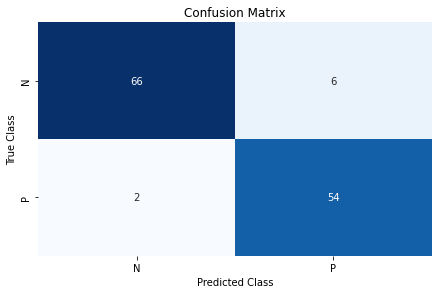

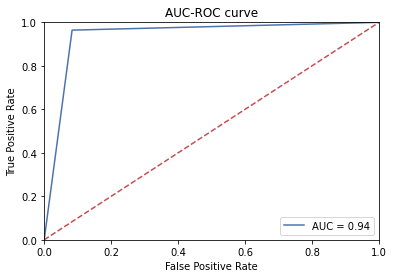

In [65]:
scaler = StandardScaler()
lr_classifier = LogisticRegression()

X_train_upsampled_transformed = scaler.fit_transform(X_train_upsampled)
X_test_upsampled_transformed = scaler.transform(X_test_upsampled)

solver = ['liblinear']
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparameters = dict(solver=solver, C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(lr_classifier, hyperparameters, cv=5, verbose=0, n_jobs=-1)

# Fit grid search
gs_best_model = gridsearch.fit(X_train_upsampled_transformed, y_train_upsampled)

print("Best params: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)
print()

lr_prediction_upsampled = gs_best_model.predict(X_test_upsampled_transformed)

# model evaluation
eval_model(y_test_upsampled, lr_prediction_upsampled)

# Create confusion matrix
matrix = confusion_matrix(y_test_upsampled, lr_prediction_upsampled)
plot_conf_matrix(matrix)

# Roc-auc curve
auc_roc_plot(y_test_upsampled, lr_prediction_upsampled)

### Recursive feature elimination - RFE (Dimensionality reduction)

In [66]:
lr_classifier = LogisticRegression()
lr_classifier.set_params(**gs_best_model.best_estimator_.get_params())

rfe_model = RFE(lr_classifier, n_features_to_select = 12)

rfe_prediction = rfe_model.fit(X_train_upsampled_transformed, y_train_upsampled)
feature_list = rfe_prediction.get_support(indices=True)
key_columns = []
for feature in feature_list:
    print(df_upsampled.columns[feature])
    key_columns.append(df_upsampled.columns[feature])
key_columns.append("class")

Age
Gender
Polyuria
Polydipsia
sudden weight loss
Polyphagia
Genital thrush
visual blurring
Itching
Irritability
delayed healing
muscle stiffness


In [67]:
columns_to_remove = []
df_rfe = df_upsampled.copy(deep=True)
for column in df_rfe.columns:
    if column not in key_columns:
        columns_to_remove.append(column)
        
rfe_removed = df_rfe.drop(columns_to_remove, axis=1)
rfe_removed.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,muscle stiffness,class
0,40,1,0,1,0,0,0,0,1,0,1,1,1
1,58,1,0,0,0,0,0,1,0,0,0,0,1
2,41,1,1,0,0,1,0,0,1,0,1,1,1
3,45,1,0,0,1,1,1,0,1,0,1,0,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1


Accuracy :  0.9296875
F1 Score:  0.9174311926605505
Precision:  0.9433962264150944
Recall:  0.8928571428571429
Confuse matrix:
[[69  3]
 [ 6 50]]
True positive:  50
False positive:  3
True negative:  69
False negative:  6
Sensitivity:  0.8928571428571429
Specificity:  0.9583333333333334


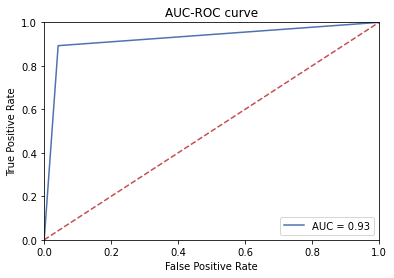

In [68]:
X = rfe_removed.drop("class", axis = 1).values
y = rfe_removed["class"].values
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X, y, test_size = 0.2, random_state = 1)

lr_classifier = LogisticRegression()
lr_classifier.set_params(**gs_best_model.best_estimator_.get_params())
lr_classifier.fit(X_train_rfe, y_train_rfe)
rfe_prediction = lr_classifier.predict(X_test_rfe)

eval_model(y_test_upsampled, rfe_prediction)

auc_roc_plot(y_test_upsampled, rfe_prediction)

### Principal component analysis - PCA (Dimensionality reduction)

Accuracy :  0.9296875
F1 Score:  0.9158878504672897
Precision:  0.9607843137254902
Recall:  0.875
Confuse matrix:
[[70  2]
 [ 7 49]]
True positive:  49
False positive:  2
True negative:  70
False negative:  7
Sensitivity:  0.875
Specificity:  0.9722222222222222


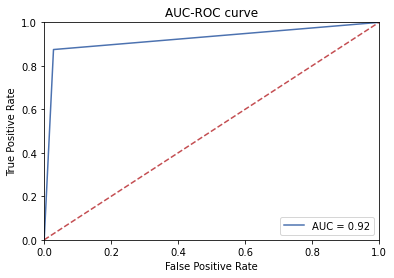

In [69]:
pca = PCA(n_components = 12)
X_train_upsampled_pca = pca.fit_transform(X_train_upsampled_transformed)
X_test_upsampled_pca = pca.transform(X_test_upsampled_transformed)

lr_classifier = LogisticRegression()
lr_classifier.set_params(**gs_best_model.best_estimator_.get_params()) 

lr_classifier.fit(X_train_upsampled_pca, y_train_upsampled)
pca_prediction = lr_classifier.predict(X_test_upsampled_pca)

eval_model(y_test_upsampled, pca_prediction)

auc_roc_plot(y_test_upsampled, pca_prediction)